## <center> Prova [02] - Inteligência Artificial / UFPB - 2021.2 </center>
**Discente:** Lucas Gomes Dantas <br>
**Matrícula:** 20200082925 <br>
**Dataset:** <a href="https://www.kaggle.com/datasets/csafrit2/higher-education-students-performance-evaluation">Higher Education Students Performance Evaluation</a>


***

> **[*] Ambiente e Dependências**

In [9]:
from statistics import mode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import six
import sys
import pickle
import warnings 

sys.modules['sklearn.externals.six'] = six

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from pandas import DataFrame
from warnings import simplefilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, classification_report)
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

simplefilter("ignore")
warnings.filterwarnings("ignore")

from autosklearn import regression, classification
from autosklearn.classification import AutoSklearnClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE, KMeansSMOTE

from collections import Counter


**1 -** Utilizando a base de dados de <a href="https://www.kaggle.com/datasets/csafrit2/higher-education-students-performance-evaluation">Higher Education Students Performance Evaluation</a>, elabore uma solução para identificar o OUTPUT Grade do estudante.  <br>


> **[#] Dataset**

In [10]:
dstudent = pd.read_csv('student_prediction.csv')
dstudent.head()

,STUDENTID,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,...,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


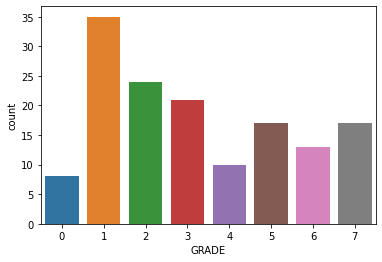

In [11]:
graphstd = sns.countplot(dstudent['GRADE'], label = 'Count')
plt.show()

> **1 [A]** - Faça o pré-processamento dos dados (limpeza, engenharia de variáveis, etc) e deixe os seus dados preparados para aplicar o modelo.<br>


>> **[#] Pré-processamento**

In [12]:
dstudent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 33 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   STUDENTID      145 non-null    object
 1   AGE            145 non-null    int64 
 2   GENDER         145 non-null    int64 
 3   HS_TYPE        145 non-null    int64 
 4   SCHOLARSHIP    145 non-null    int64 
 5   WORK           145 non-null    int64 
 6   ACTIVITY       145 non-null    int64 
 7   PARTNER        145 non-null    int64 
 8   SALARY         145 non-null    int64 
 9   TRANSPORT      145 non-null    int64 
 10  LIVING         145 non-null    int64 
 11  MOTHER_EDU     145 non-null    int64 
 12  FATHER_EDU     145 non-null    int64 
 13  #_SIBLINGS     145 non-null    int64 
 14  KIDS           145 non-null    int64 
 15  MOTHER_JOB     145 non-null    int64 
 16  FATHER_JOB     145 non-null    int64 
 17  STUDY_HRS      145 non-null    int64 
 18  READ_FREQ      145 non-null   

>> Todos os dados são numéricos, então não há necessidade de conversão.

In [13]:
dstudent.shape

(145, 33)

In [14]:
dstudent.describe(include=object)

,STUDENTID
count,145
unique,145
top,STUDENT1
freq,1


>>> Apresenta a disposição dos dados para os atributos do tipo object e sua incidência de valores e singularidade.

In [15]:
dstudent = dstudent.drop(['STUDENTID', 'COURSE ID'], axis = 1)

>>> Removendo atributos de ID, pois é irrelevante ao contexto.

In [16]:
dstudent = dstudent.drop_duplicates()
dstudent = dstudent.dropna()

>> Removendos dados duplicados e nulos.

In [17]:
double = dstudent[dstudent.duplicated()]
double

,AGE,GENDER,HS_TYPE,SCHOLARSHIP,WORK,ACTIVITY,PARTNER,SALARY,TRANSPORT,LIVING,...,ATTEND,PREP_STUDY,PREP_EXAM,NOTES,LISTENS,LIKES_DISCUSS,CLASSROOM,CUML_GPA,EXP_GPA,GRADE


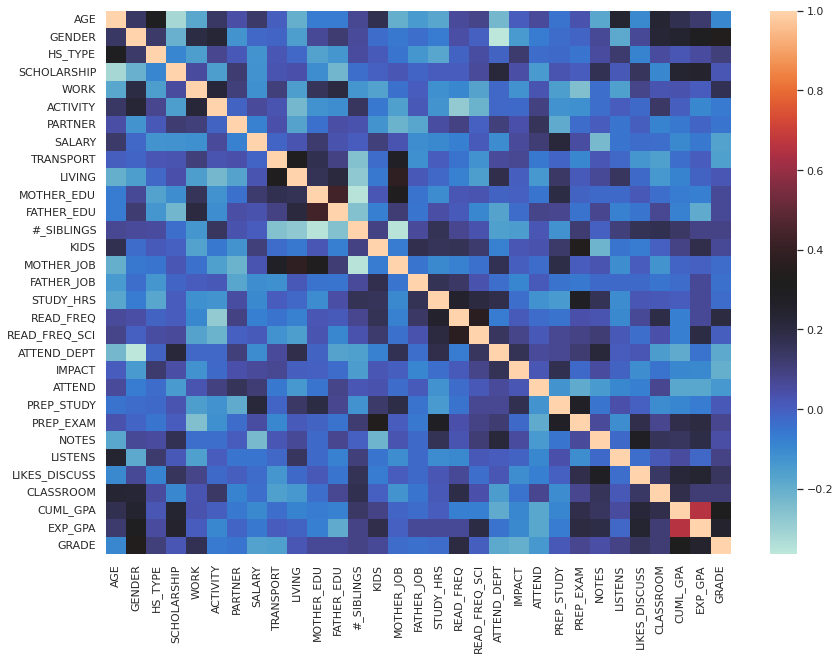

In [147]:
plt.figure(figsize=(14, 10))
sns.heatmap(dstudent.corr(), cmap = "icefire")
plt.show()

>>> Ao avaliar o gráfico é possível identificar uma incidência maior de correlção entre "EXP_GPA" em relação ao "CUML_GPA". Devido ao caráter preditivo de um dos atributos em relação ao outro, será feito a primeiro momento a remoção do "EXP_GPA" e avaliado posteriormente.

In [19]:
dstudent_fix = dstudent.drop(['EXP_GPA'], axis = 1)

>>> **1 [A - a]** Utilize pelo menos uma forma de redimensionamento de atributos (selecionando ou agregando) e avalie o resultado de utilizar todas eles e essa amostra.


In [20]:
dstudent.corr()['GRADE']

AGE             -0.095251
GENDER           0.335533
HS_TYPE          0.104821
SCHOLARSHIP      0.023963
WORK             0.167445
ACTIVITY        -0.062993
PARTNER         -0.051778
SALARY          -0.166352
TRANSPORT       -0.156289
LIVING           0.023683
MOTHER_EDU       0.066318
FATHER_EDU       0.063504
#_SIBLINGS       0.084470
KIDS             0.066379
MOTHER_JOB      -0.030747
FATHER_JOB      -0.044268
STUDY_HRS       -0.033065
READ_FREQ        0.195617
READ_FREQ_SCI    0.003189
ATTEND_DEPT     -0.184763
IMPACT          -0.203273
ATTEND          -0.139564
PREP_STUDY       0.014638
PREP_EXAM        0.073783
NOTES            0.044862
LISTENS          0.085137
LIKES_DISCUSS    0.146547
CLASSROOM        0.110617
CUML_GPA         0.315493
EXP_GPA          0.248588
GRADE            1.000000
Name: GRADE, dtype: float64

>>> Ao relacionar o atributo GRADE com os demais, é possível identificar a incidência de correlações menores que 0.1 e -0.1, caracterizando uma não correlação. Através dessa condição, irei retirar todos os atributos que atendem a essa característica e verificar o comportamento do dataset posteriormente.

In [21]:
dstudent_test = dstudent_fix.copy()

dstudent_test = dstudent_test.drop(['AGE', 'SCHOLARSHIP', 'ACTIVITY', 'PARTNER', 'LIVING', 'MOTHER_EDU', 'FATHER_EDU', '#_SIBLINGS', 'KIDS', 'MOTHER_JOB', 'FATHER_JOB', 'STUDY_HRS', 'READ_FREQ_SCI', 'PREP_STUDY', 'PREP_EXAM', 'NOTES', 'LISTENS' ], axis = 1)

In [22]:
dstudent_test.head()

,GENDER,HS_TYPE,WORK,SALARY,TRANSPORT,READ_FREQ,ATTEND_DEPT,IMPACT,ATTEND,LIKES_DISCUSS,CLASSROOM,CUML_GPA,GRADE
0,2,3,1,1,1,2,1,1,1,1,2,1,1
1,2,3,1,1,1,2,1,1,1,3,2,2,1
2,2,2,2,2,4,1,1,1,1,1,1,2,1
3,1,1,1,2,1,1,1,1,1,2,1,3,1
4,2,1,2,3,1,1,1,1,1,2,1,2,1


> **1 [B]** - Faça uma análise exploratória dos dados de saída, utilizando box plot, mostrando a aplicação de técnicas de under ou oversampling para que as classes tenham o mesmo tamanho. <br>

In [23]:
sns.set_theme(style="whitegrid")

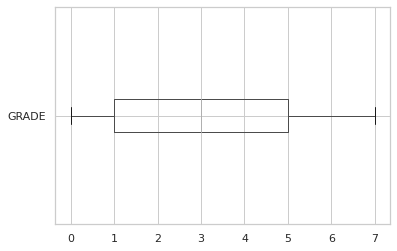

In [24]:
dstudent.boxplot(column=['GRADE'], vert = False)
plt.show()

>> O boxplot indica uma concentração maior de notas onde incide os menores valores, tendenciando os dados. Diante desse cenário, será aplicada a técnica de oversampling para igualar as menores notas em sentido quantitativo de elementos.

In [25]:
dstudent['GRADE'].value_counts()

1    35
2    24
3    21
5    17
7    17
6    13
4    10
0     8
Name: GRADE, dtype: int64

In [26]:
## Balanceador

k_smt = KMeansSMOTE(kmeans_estimator=1, n_jobs=-1, random_state=42, cluster_balance_threshold=0)

In [27]:
dstudent_anon = dstudent.drop(labels=['GRADE'], axis=1)

dstudent_anon, dstudent_grade = k_smt.fit_resample(dstudent_anon, dstudent['GRADE'])
dstudent_balanced = pd.concat([dstudent_anon, dstudent_grade], axis=1)

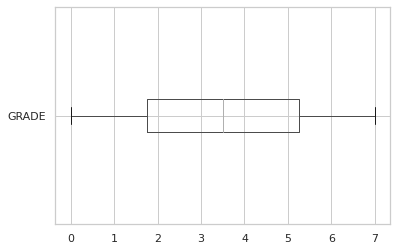

In [146]:
dstudent_balanced.boxplot(column=['GRADE'], vert = False)
plt.show()

>> Após a aplicação do oversampling aos dados, a mediana agora está localizada no centro, estando devidamente balanceada.

> **1 [C]** - Utilize a biblioteca AUTOML para fazer a previsão. Para o melhor algoritmo, teste 3 variações de um dos seus hiperparâmetros. <br>

> **1 [D]** - Para avaliar os resultados, utilize e explique a matriz de confusão. Além disso, escolha 2 métricas de sua preferência e o que o seu resultado significa. <br>


In [29]:
## dstudent_fix_x = dstudent_fix.iloc[:, :-1]
## dstudent_fix_y = dstudent_fix.iloc[:, -1]

## dstudent_test_x = dstudent_test.iloc[:, :-1]
## dstudent_test_y = dstudent_test.iloc[:, -1]

In [30]:
dstudent_x = dstudent_balanced.iloc[:, :-1].values
dstudent_y = dstudent_balanced.iloc[:, -1].values

(dstudent_x.shape, dstudent_y.shape)

((280, 30), (280,))

>> Definindo os dados de treinamento e teste.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(dstudent_x, dstudent_y, test_size=0.33, random_state=42, stratify=dstudent_y)

In [32]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((187, 30), (187,)), ((93, 30), (93,)))

In [ ]:
autosk = AutoSklearnClassifier(
    time_left_for_this_task=60 * (5),
    per_run_time_limit=25,
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 10},
    n_jobs =-1
)

autosk.fit(X_train, y_train)
autosk.refit(X_train, y_train)

In [321]:
predictions = autosk.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, predictions)}")
print("")

print(autosk.leaderboard())

Acurácia: 0.7849462365591398

          rank  ensemble_weight           type      cost   duration
model_id                                                           
2            1             0.06  random_forest  0.315508  17.602997
54           2             0.02  random_forest  0.320856  15.619362
22           3             0.02  random_forest  0.320856  18.363211
7            4             0.04     libsvm_svc  0.342246   8.503115
5            5             0.02     libsvm_svc  0.379679   5.709465
34           6             0.04  random_forest  0.379679  16.464487
43           7             0.02  random_forest  0.427807  22.177441
48           8             0.02  random_forest  0.470588  19.543325
47           9             0.02  random_forest  0.513369  20.665099
36          10             0.64       adaboost  0.524064  14.465663
28          11             0.10   bernoulli_nb  0.786096  10.567344


In [35]:
# Grava o modelo e seus respectivos hiperparâmetros

# with open('predict-grade.pkl', 'wb')  as f:
    # pickle.dump(autosk, f)

In [322]:
# Carrega o modelo e seus respectivos hiperparâmetros

with open('random-forest-78.pkl', 'rb') as f:
    loaded_classifier = pickle.load(f)

In [1049]:
y_true = y_test
y_pred = loaded_classifier.predict(X_test)

print("Melhor modelo de testes - Radom-forest")
print("")

print(f"Melhor acurácia: {accuracy_score(y_true, y_pred)}")

Melhor modelo de testes - Radom-forest

Melhor acurácia: 0.7849462365591398


In [1050]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.38      0.91      0.54        11
           2       0.89      0.67      0.76        12
           3       0.86      0.50      0.63        12
           4       1.00      0.83      0.91        12
           5       1.00      0.64      0.78        11
           6       1.00      0.92      0.96        12
           7       0.85      0.92      0.88        12

    accuracy                           0.78        93
   macro avg       0.87      0.79      0.80        93
weighted avg       0.87      0.78      0.80        93



>>> Hiperparâmetros do AUTOML

In [1051]:
report = DataFrame(autosk.cv_results_).sort_values(by=["rank_test_scores"])
bestParams = report.loc[report.rank_test_scores == 1, "params"].squeeze()

dparams_items = bestParams.items()
dparams = pd.DataFrame(dparams_items)

dparams_aligned = dparams.style.set_properties(**{'text-align': 'left'})

dparams_aligned

,0,1
0,balancing:strategy,none
1,classifier:__choice__,random_forest
2,data_preprocessor:__choice__,feature_type
3,feature_preprocessor:__choice__,no_preprocessing
4,classifier:random_forest:bootstrap,True
5,classifier:random_forest:criterion,gini
6,classifier:random_forest:max_depth,None
7,classifier:random_forest:max_features,0.500000
8,classifier:random_forest:max_leaf_nodes,None
9,classifier:random_forest:min_impurity_decrease,0.000000


>>> Aplicando os teste em 3 modelos alterando seus hiperparâmetros.

In [1052]:
from sklearn.ensemble import RandomForestClassifier

## Melhores parâmetros do autosklearn

best_params = {
    "bootstrap": True,
    "criterion": "gini",
    "max_depth": None,
    "max_features": 0.500000,
    "max_leaf_nodes": None,
    "random_state": 21,
    "min_impurity_decrease": 0.00,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.00,
}

p = [best_params.copy(), best_params.copy(), best_params.copy()]

# Modelo 1
p[0].update({"max_features": 0.1})
# Modelo 2
p[1].update({"max_features": 0.9})
# Modelo 3
p[2].update({"max_features": 1.0})

rf = RandomForestClassifier(**best_params)

>>> Criando um dicionário com base nos hiperparâmetros dados pelo AUTOML.

In [1053]:
## Modelo base

rf.fit(X_train, y_train)
predict = rf.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, predict)}")
print(f"Precisão: {precision_score(y_test, predict, average='macro')}")

Acurácia: 0.7849462365591398
Precisão: 0.7830419580419581


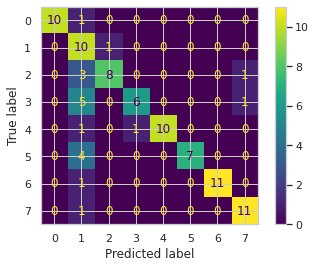

In [1054]:
matrix = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot()
plt.show()

In [1055]:
## Modelo 1

rf = RandomForestClassifier(**p[0])

rf.fit(X_train, y_train)
predict1 = rf.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, predict1)}")
print(f"Precisão: {precision_score(y_test, predict1 , average='macro')}")

Acurácia: 0.7419354838709677
Precisão: 0.7500022546897547


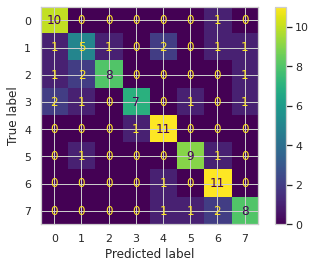

In [1056]:
matrix1 = confusion_matrix(y_test, predict1)
ConfusionMatrixDisplay(confusion_matrix=matrix1).plot()
plt.show()

In [1057]:
## Modelo 2

rf = RandomForestClassifier(**p[1])

rf.fit(X_train, y_train)
predict2 = rf.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, predict2)}")
print(f"Precisão: {precision_score(y_test, predict2 , average='macro')}")

Acurácia: 0.7096774193548387
Precisão: 0.6885281385281385


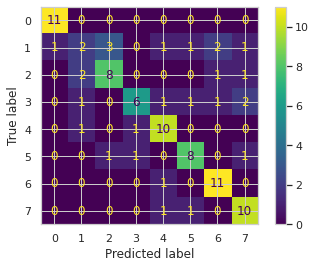

In [1058]:
matrix2 = confusion_matrix(y_test, predict2)
ConfusionMatrixDisplay(confusion_matrix=matrix2).plot()
plt.show()

In [1059]:
## Modelo 3

rf = RandomForestClassifier(**p[2])

rf.fit(X_train, y_train)
predict3 = rf.predict(X_test)

print(f"Acurácia: {accuracy_score(y_test, predict3)}")
print(f"Precisão: {precision_score(y_test, predict3, average='macro')}")

Acurácia: 0.7204301075268817
Precisão: 0.7135843731431967


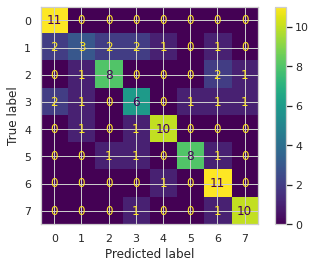

In [1060]:
matrix3 = confusion_matrix(y_test, predict3)
ConfusionMatrixDisplay(confusion_matrix=matrix3).plot()
plt.show()

**2 -** Utilize a mesma base de dados (lembrem de tirar o rótulo, obviamente) da questão anterior de forma que:

> **2 [A]** - Execute o K-means e Hierárquico. <br>

> **2 [B]** - Teste o K igual à 5 e 7. <br>

> **2 [C]** - Na execução do Hierárquico, varie 2 métodos do linkage. <br>

> **2 [D]** - Por fim, faça uma comparação entre os 2 resultados das execuções anteriores e adote uma medida de avaliação própria para clusterização. <br>

**BÔNUS** - Diga vantagens e desvantagens do uso do AUTOML e como você faria para usá-lo, garantindo os melhores resultados possíveis. <br>

***

In [1061]:
#!pip3 install math
#!pip3 install matplotlib
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install statistics 
#!pip3 install sklearn